In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
#import torch.utils.tensorboard as tb
from Preprocessing.preprocessing import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd
from Postprocessing.postprocessing import PostProcessing

In [3]:
#static parameters
train_batch_size = 170
val_batch_size = 170
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [4]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [5]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [6]:
#network_output

In [7]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [8]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [9]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -117]
network_output = network_output[: -117]

print(network_input.shape)
print(network_output.shape)

torch.Size([8500, 50, 1])
torch.Size([8500])


In [20]:
# # Bakchodi Normalization
# network_input=network_input.cpu().numpy().tolist()
# for i in range(len(network_input)):
#     for j in range(len(network_input[i])):
#         network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
# network_input=torch.Tensor(network_input).cuda()

In [21]:
#network_input[:10]

In [10]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) 

In [11]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [12]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [13]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [14]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output = model.forward(inputs, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        #logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        output = model.forward(inputs, val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38_our_normalization.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.3446208 	Val Loss:3.0100807 	Train Acc: 7.808824% 	Val Acc: 11.4117651%
Validation Loss decreased from    inf to 3.010081, saving the model weights
Epoch: 1	Train Loss: 3.1425091 	Val Loss:2.9826850 	Train Acc: 9.132353% 	Val Acc: 11.4117651%
Validation Loss decreased from 3.010081 to 2.982685, saving the model weights
Epoch: 2	Train Loss: 3.1131256 	Val Loss:2.9613094 	Train Acc: 8.294118% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.982685 to 2.961309, saving the model weights
Epoch: 3	Train Loss: 3.0987655 	Val Loss:2.9609893 	Train Acc: 9.205883% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.961309 to 2.960989, saving the model weights
Epoch: 4	Train Loss: 3.0920197 	Val Loss:2.9544968 	Train Acc: 8.838236% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.960989 to 2.954497, saving the model weights
Epoch: 5	Train Loss: 3.0762066 	Val Loss:2.9481595 	Train Acc: 9.57353% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.954497 to 

Epoch: 53	Train Loss: 2.4192681 	Val Loss:2.3860807 	Train Acc: 19.25% 	Val Acc: 17.7647062%
Epoch: 54	Train Loss: 2.4192419 	Val Loss:2.3764142 	Train Acc: 19.41177% 	Val Acc: 17.8235298%
Epoch: 55	Train Loss: 2.4108529 	Val Loss:2.3820433 	Train Acc: 19.69118% 	Val Acc: 18.5294122%
Epoch: 56	Train Loss: 2.4039810 	Val Loss:2.3763202 	Train Acc: 19.58824% 	Val Acc: 17.9411768%
Epoch: 57	Train Loss: 2.4039505 	Val Loss:2.3679344 	Train Acc: 19.38235% 	Val Acc: 17.1176475%
Validation Loss decreased from 2.374141 to 2.367934, saving the model weights
Epoch: 58	Train Loss: 2.3987224 	Val Loss:2.3630337 	Train Acc: 19.63235% 	Val Acc: 18.8235298%
Validation Loss decreased from 2.367934 to 2.363034, saving the model weights
Epoch: 59	Train Loss: 2.4040757 	Val Loss:2.3608697 	Train Acc: 19.91177% 	Val Acc: 19.4705886%
Validation Loss decreased from 2.363034 to 2.360870, saving the model weights
Epoch: 60	Train Loss: 2.3933937 	Val Loss:2.3607222 	Train Acc: 20.02941% 	Val Acc: 17.7058828%
V

Validation Loss decreased from 2.077623 to 2.062018, saving the model weights
Epoch: 115	Train Loss: 2.1362804 	Val Loss:2.0760272 	Train Acc: 29.44118% 	Val Acc: 30.0000010%
Epoch: 116	Train Loss: 2.1228648 	Val Loss:2.1012772 	Train Acc: 29.75% 	Val Acc: 28.6470594%
Epoch: 117	Train Loss: 2.0996368 	Val Loss:2.0902095 	Train Acc: 30.88235% 	Val Acc: 29.2941184%
Epoch: 118	Train Loss: 2.1206163 	Val Loss:2.0577907 	Train Acc: 29.95588% 	Val Acc: 30.8235304%
Validation Loss decreased from 2.062018 to 2.057791, saving the model weights
Epoch: 119	Train Loss: 2.0887333 	Val Loss:2.0695171 	Train Acc: 31.19118% 	Val Acc: 31.2941188%
Epoch: 120	Train Loss: 2.0975074 	Val Loss:2.0909365 	Train Acc: 30.33824% 	Val Acc: 30.0588246%
Epoch: 121	Train Loss: 2.0828688 	Val Loss:2.0675716 	Train Acc: 31.11765% 	Val Acc: 31.5294126%
Epoch: 122	Train Loss: 2.0837955 	Val Loss:2.1294379 	Train Acc: 31.47059% 	Val Acc: 27.9411773%
Epoch: 123	Train Loss: 2.1034702 	Val Loss:2.0936185 	Train Acc: 30.441

Epoch: 176	Train Loss: 1.6232459 	Val Loss:1.4733730 	Train Acc: 47.16177% 	Val Acc: 54.1764709%
Epoch: 177	Train Loss: 1.6004480 	Val Loss:1.4083323 	Train Acc: 48.38235% 	Val Acc: 56.8823540%
Validation Loss decreased from 1.451705 to 1.408332, saving the model weights
Epoch: 178	Train Loss: 1.5890505 	Val Loss:1.4231391 	Train Acc: 48.20588% 	Val Acc: 56.7647079%
Epoch: 179	Train Loss: 1.5604677 	Val Loss:1.3765319 	Train Acc: 49.63235% 	Val Acc: 56.6470593%
Validation Loss decreased from 1.408332 to 1.376532, saving the model weights
Epoch: 180	Train Loss: 1.5621078 	Val Loss:1.3764940 	Train Acc: 48.98529% 	Val Acc: 57.1176475%
Validation Loss decreased from 1.376532 to 1.376494, saving the model weights
Epoch: 181	Train Loss: 1.5526067 	Val Loss:1.4249021 	Train Acc: 49.04412% 	Val Acc: 56.2941182%
Epoch: 182	Train Loss: 1.5859152 	Val Loss:1.3543179 	Train Acc: 48.32353% 	Val Acc: 59.4117650%
Validation Loss decreased from 1.376494 to 1.354318, saving the model weights
Epoch: 18

Epoch: 243	Train Loss: 0.9137364 	Val Loss:0.6426551 	Train Acc: 71.27941% 	Val Acc: 83.1764698%
Epoch: 244	Train Loss: 0.9285711 	Val Loss:0.6597871 	Train Acc: 70.22059% 	Val Acc: 81.7058814%
Epoch: 245	Train Loss: 0.8892465 	Val Loss:0.6947488 	Train Acc: 71.92647% 	Val Acc: 81.2352931%
Epoch: 246	Train Loss: 0.8780314 	Val Loss:0.7436654 	Train Acc: 72.08824% 	Val Acc: 78.6470592%
Epoch: 247	Train Loss: 0.8708497 	Val Loss:0.8776915 	Train Acc: 72.41177% 	Val Acc: 73.6470592%
Epoch: 248	Train Loss: 0.8849610 	Val Loss:0.6272041 	Train Acc: 71.32353% 	Val Acc: 83.5882342%
Epoch: 249	Train Loss: 0.8393839 	Val Loss:0.6309623 	Train Acc: 73.17647% 	Val Acc: 82.3529398%
Epoch: 250	Train Loss: 0.8417565 	Val Loss:0.6534748 	Train Acc: 72.57353% 	Val Acc: 80.9411764%
Epoch: 251	Train Loss: 0.8353992 	Val Loss:0.6027658 	Train Acc: 73.72059% 	Val Acc: 83.9999998%
Validation Loss decreased from 0.611638 to 0.602766, saving the model weights
Epoch: 252	Train Loss: 0.8086177 	Val Loss:0.6136

Epoch: 312	Train Loss: 0.4479332 	Val Loss:0.1842815 	Train Acc: 86.16176% 	Val Acc: 95.7647043%
Epoch: 313	Train Loss: 0.4360884 	Val Loss:0.1687448 	Train Acc: 86.5147% 	Val Acc: 96.3529396%
Validation Loss decreased from 0.169793 to 0.168745, saving the model weights
Epoch: 314	Train Loss: 0.4381494 	Val Loss:0.1629275 	Train Acc: 86.52941% 	Val Acc: 96.4705867%
Validation Loss decreased from 0.168745 to 0.162928, saving the model weights
Epoch: 315	Train Loss: 0.4093408 	Val Loss:0.1735010 	Train Acc: 87.67647% 	Val Acc: 95.8235288%
Epoch: 316	Train Loss: 0.4247738 	Val Loss:0.1652310 	Train Acc: 86.97059% 	Val Acc: 96.0588223%
Epoch: 317	Train Loss: 0.4314558 	Val Loss:0.1914353 	Train Acc: 87.01471% 	Val Acc: 95.2352923%
Epoch: 318	Train Loss: 0.4357536 	Val Loss:0.1770897 	Train Acc: 86.44118% 	Val Acc: 95.5294096%
Epoch: 319	Train Loss: 0.4261527 	Val Loss:0.1877720 	Train Acc: 86.77941% 	Val Acc: 94.9411762%
Epoch: 320	Train Loss: 0.4394156 	Val Loss:0.1899088 	Train Acc: 86.0

Epoch: 381	Train Loss: 0.2364316 	Val Loss:0.0578845 	Train Acc: 93.13235% 	Val Acc: 98.9411753%
Epoch: 382	Train Loss: 0.2310744 	Val Loss:0.0487817 	Train Acc: 92.89706% 	Val Acc: 99.2352921%
Validation Loss decreased from 0.055721 to 0.048782, saving the model weights
Epoch: 383	Train Loss: 0.2221326 	Val Loss:0.0462122 	Train Acc: 93.42647% 	Val Acc: 99.2941171%
Validation Loss decreased from 0.048782 to 0.046212, saving the model weights
Epoch: 384	Train Loss: 0.2228993 	Val Loss:0.0461014 	Train Acc: 93.54412% 	Val Acc: 99.2941165%
Validation Loss decreased from 0.046212 to 0.046101, saving the model weights
Epoch: 385	Train Loss: 0.2218558 	Val Loss:0.0415609 	Train Acc: 93.79412% 	Val Acc: 99.3529403%
Validation Loss decreased from 0.046101 to 0.041561, saving the model weights
Epoch: 386	Train Loss: 0.2041023 	Val Loss:0.0401895 	Train Acc: 94.04412% 	Val Acc: 99.3529397%
Validation Loss decreased from 0.041561 to 0.040189, saving the model weights
Epoch: 387	Train Loss: 0.206

Epoch: 449	Train Loss: 0.1617241 	Val Loss:0.0433864 	Train Acc: 95.22059% 	Val Acc: 98.9411747%
Epoch: 450	Train Loss: 0.1910868 	Val Loss:0.0628820 	Train Acc: 94.42647% 	Val Acc: 98.7647045%
Epoch: 451	Train Loss: 0.2038781 	Val Loss:0.0413725 	Train Acc: 93.69118% 	Val Acc: 98.9999992%
Epoch: 452	Train Loss: 0.2059736 	Val Loss:0.0337959 	Train Acc: 93.72059% 	Val Acc: 99.1764694%
Epoch: 453	Train Loss: 0.1894423 	Val Loss:0.0326292 	Train Acc: 93.91176% 	Val Acc: 98.9999986%
Epoch: 454	Train Loss: 0.1813995 	Val Loss:0.0368283 	Train Acc: 94.36765% 	Val Acc: 99.1176462%
Epoch: 455	Train Loss: 0.1834255 	Val Loss:0.0399858 	Train Acc: 94.23529% 	Val Acc: 98.9411747%
Epoch: 456	Train Loss: 0.2151810 	Val Loss:0.0434600 	Train Acc: 93.29412% 	Val Acc: 99.1764700%
Epoch: 457	Train Loss: 0.2270973 	Val Loss:0.0441765 	Train Acc: 93.36765% 	Val Acc: 98.8823527%
Epoch: 458	Train Loss: 0.2130835 	Val Loss:0.0364071 	Train Acc: 94.17647% 	Val Acc: 98.9999992%
Epoch: 459	Train Loss: 0.24947

## MUSIC GENERATION

In [25]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38_our_normalization.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [26]:
#load population database
#testing_data = np.ones(200)*1
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data_rev.extend(testing_data_rev)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [27]:
#abc

In [28]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)
#     list1[i]=(list1[i])/(89)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [29]:
#testing_data

In [30]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, min_note,test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output = test_model.forward(test_slice, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        
        test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_note)/(max_note - min_note)
#         test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [31]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number, min_midi_number)

In [32]:
#predicted_notes_lst

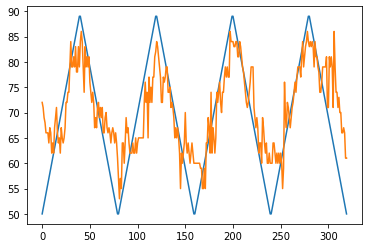

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [34]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 19,
         71: 15,
         69: 15,
         68: 1,
         66: 16,
         64: 25,
         67: 20,
         62: 26,
         65: 16,
         74: 21,
         79: 30,
         84: 16,
         81: 15,
         83: 11,
         78: 4,
         86: 4,
         76: 9,
         70: 5,
         61: 3,
         57: 2,
         53: 1,
         55: 6,
         60: 20,
         77: 12,
         75: 2,
         82: 1,
         59: 4,
         73: 1})

In [ ]:
PostProcessing().generate_midi_file('hello.midi', predicted_notes_lst)